# Sprawozdanie
**Z projektu dotyczącego predykcji szeregów czasowych** \
*Autor: Ewa Szewczyk, nr indeksu: 406923*

Celem projektu było przeprowadzenie analizy i predykcji szeregów czasowych dotyczących poziomu pyłu zawieszonego przy użyciu modelu XGBoost.

<div style="text-align: justify"> W projekcie wykorzystano dane udostępnione przez GIOŚ (Główny Inspektorat Ochrony Środowiska) za rok 2019 dotyczące pomiarów PM2.5 w godzinnych odstępach. Do zlokalizowania stacji wykorzystano plik udostępniany przez GIOŚ zawierający takie informacje jak współrzędne geograficzne, adres, województwo czy rodzaj stacji pomiarowej.</div>

### Ustawienia notatnika

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb

sns.set_theme('notebook') 

## Część 1: Przygotowanie danych i inżynieria cech

### Wczytanie danych i dodanie cech lokalizacyjnych
Pierwszym etapem prac było wczytanie danych, poprawienie nazw kolumn oraz połączenie danych pomiarowych z lokalizacjami poszczególnych stacji.

In [86]:
# Wczytanie danych pomiarowych

# Wczytanie danych z excela
pm_df = pd.read_excel('2019_PM25_1g.xlsx', skiprows=5) \
    .melt(id_vars=['Kod stanowiska'],var_name='station_code', value_name='PM25') 

pm_df = pm_df.rename(columns={'Kod stanowiska': 'date'})
pm_df['station_code'] = pm_df.station_code.str[:-9]

# Mapowanie przestarzałych nazw stacji
stations_mapper = {'LbNaleczow': 'LbNaleczAlMa', 'MzKonJezMos': 'MzKonJezWieMOB', 'PdSuwPulaskp': 'PdSuwPulask2', 'PmGdaLeczk08': 'PmGdaLeczkow',
                    'ZpSzczAndr01': 'ZpSzczAndrze', 'ZpSzczPils02': 'ZpSzczPilsud'}
pm_df['station_code'] = pm_df.station_code.replace(stations_mapper)

pm_df.head()

,date,station_code,PM25
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722


In [87]:
# Wczytanie lokalizacji stacji pomiarowych
colnames = ['N', 'station_code', 'international_code', 'name', 'old_station_code', 'date_opening', 'date_closing', 'station_type',
             'region_type', 'station_location_type', 'voivodeship', 'city', 'address', 'lat', 'lon']

loc_df = pd.read_excel('Metadane oraz kody stacji i stanowisk pomiarowych.xlsx', index_col=0, names=colnames)

# Usunięcie z ramki danych stacji które zostały wyłączone z użytku przed badanym okresem
loc_df = loc_df[(loc_df.date_closing >= '2019-01-01') | (loc_df.date_closing.isna())].reset_index(drop=True)
loc_df.head()

,station_code,international_code,name,old_station_code,date_opening,date_closing,station_type,region_type,station_location_type,voivodeship,city,address,lat,lon
0,DsCzerStraza,PL0028A,Czerniawa,DsCzer02,1996-07-01,NaT,tło,pozamiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Czerniawa,ul. Strażacka 7,50.912475,15.312190
1,DsDusznikMOB,PL0733A,Duszniki-Zdrój,NaN,2019-01-01,2019-12-31,tło,miejski,mobilna,DOLNOŚLĄSKIE,Duszniki-Zdrój,Sportowa 2a,50.402645,16.393319
2,DsDzialoszyn,PL0054A,Działoszyn,DsDzia01,1996-07-01,2022-12-31,przemysłowa,pozamiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Działoszyn,NaN,50.972167,14.941319
3,DsDziePilsud,PL0187A,"Dzierżoniów, ul. Piłsudskiego",DsDzierPilsA,2005-01-01,NaT,tło,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Dzierżoniów,ul. Piłsudskiego 26,50.732817,16.648050
4,DsGlogWiStwo,PL0603A,"Głogów, ul. Wita Stwosza",DsGlogWita,2015-01-01,NaT,tło,miejski,wolnostojący pobornik pyłu,DOLNOŚLĄSKIE,Głogów,ul. Wita Stwosza 3,51.657022,16.097822


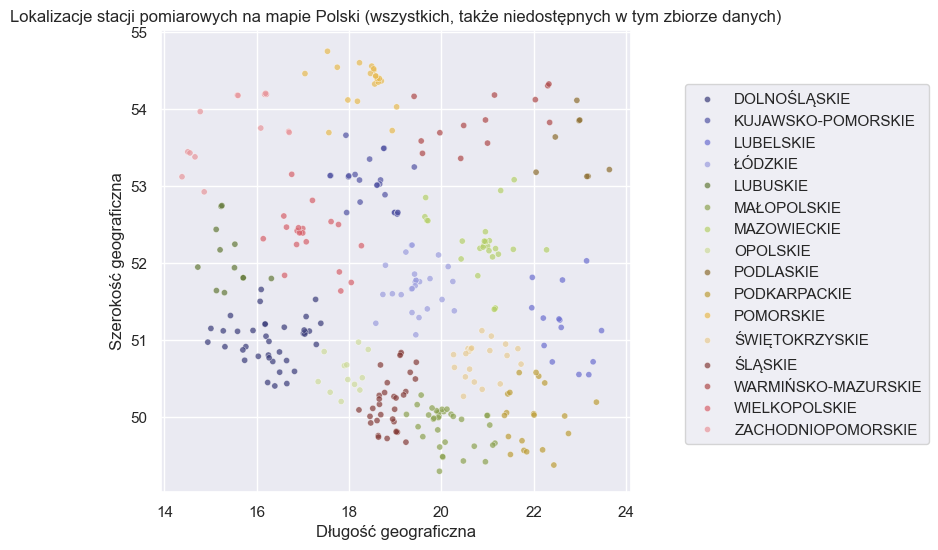

In [88]:
# Wizualizacja lokalizacji stacji

fig, ax = plt.subplots(1,1,figsize=(13,6))

sns.scatterplot(loc_df, x='lon', y='lat', alpha=0.7, s=20, hue='voivodeship', palette='tab20b')
ax.set(aspect=5/3, title='Lokalizacje stacji pomiarowych na mapie Polski (wszystkich, także niedostępnych w tym zbiorze danych)', 
       xlabel='Długość geograficzna', ylabel='Szerokość geograficzna')

ax.legend(bbox_to_anchor=(1.1, 0.9))

plt.show()

In [89]:
# Łączenie danych pomiarowych i lokalizacyjnych

print(f'Ilość rekordów w danych pomiarowych PM2.5: {len(pm_df)}')
pm_loc_df = pm_df.merge(loc_df, how='inner', on='station_code')
print(f'Ilość rekordów po połączeniu danych pomiarowych z lokalizacjami stacji: {len(pm_loc_df)}')

Ilość rekordów w danych pomiarowych PM2.5: 551880
Ilość rekordów po połączeniu danych pomiarowych z lokalizacjami stacji: 551880


Sprawdzono, czy po połączeniu danych pomiarowych i lokalizacyjnych nie zostały utracone żadne dane. W trakcie początkowych badań wykryto w ten sposób inne kody stacji pomiarowych (zostało to zaadresowane w komórce "Wczytanie danych pomiarowych")

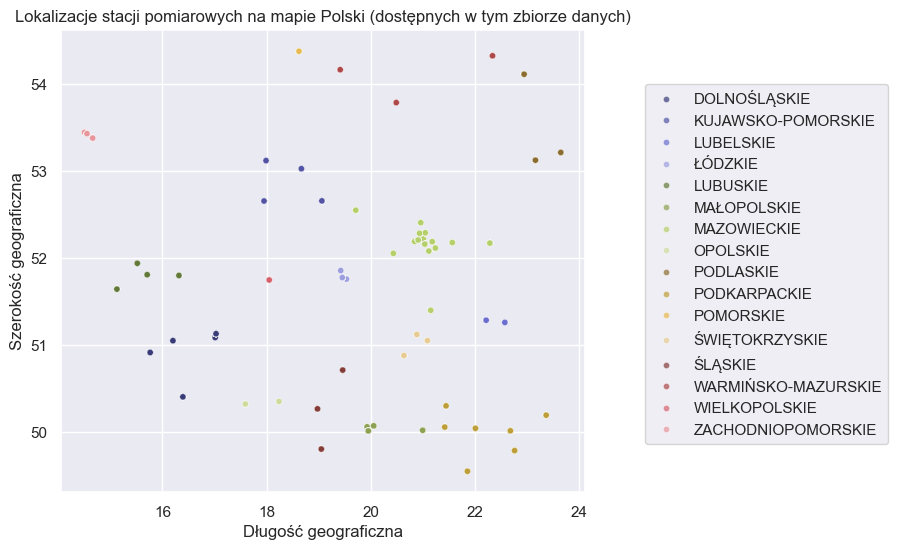

In [90]:
# Wizualizacja lokalizacji stacji (po połączeniu)

fig, ax = plt.subplots(1,1,figsize=(13,6))

sns.scatterplot(pm_loc_df, x='lon', y='lat', alpha=0.7, s=20, hue='voivodeship', palette='tab20b')
ax.set(aspect=5/3, title='Lokalizacje stacji pomiarowych na mapie Polski (dostępnych w tym zbiorze danych)', 
       xlabel='Długość geograficzna', ylabel='Szerokość geograficzna')

ax.legend(bbox_to_anchor=(1.1, 0.9))

plt.show()

In [31]:
cols_to_save = ['date', 'station_code', 'PM25', 'station_type', 'region_type', 'station_location_type', 'voivodeship', 'lat', 'lon']

df = pm_loc_df[cols_to_save]
df.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319


Z otrzymanej ramki danych usunięto kolumny, które nie są przydatne dla dalszej analizy, czyli:
- międzynarodowy kod stacji - kolumna 'station code' jednoznacznie identyfikuje stację, nie jest potrzebna do tego dodatkowa kolumna,
- nazwa - jak wyżej
- stary kod stacji - potrzebne informacje z tej kolumny zostały już wykorzystane
- data początku działania stacji - nie wpływa to w żaden sposób na wartości pomiarów
- data końca działania stacji - potrzebne informacje z tej kolumny zostały już wykorzystanie, nie wpływa ona na wartości pomiarów
- miasto - lokalizacja może być stwierdzona w dokładniejszy sposób przy użyciu współrzędnych geograficznych
- adres - lokalizacja może być stwierdzona w dokładniejszy sposób przy użyciu współrzędnych geograficznych

### EDA

In [32]:
print(f'Ilość stacji z których są pomiary: {len(df.station_code.unique())}')
print(f'Ilość rodzajów stacji: {len(df.station_type.unique())}: {", ".join(df.station_type.unique())}')

print('Ilość pomiarów dla poszczególnych typów stacji:\n')
print(df.station_type.value_counts())

print(f'\nIlość rodzajów regionów: {len(df.region_type.unique())}: {", ".join(df.region_type.unique())}')

print('Ilość pomiarów dla poszczególnych regionów:\n')
print(df.region_type.value_counts())

Ilość stacji z których są pomiary: 63
Ilość rodzajów stacji: 3: tło, komunikacyjna, przemysłowa
Ilość pomiarów dla poszczególnych typów stacji:

station_type
tło              464280
komunikacyjna     78840
przemysłowa        8760
Name: count, dtype: int64

Ilość rodzajów regionów: 3: miejski, podmiejski, pozamiejski
Ilość pomiarów dla poszczególnych regionów:

region_type
miejski        473040
podmiejski      61320
pozamiejski     17520
Name: count, dtype: int64


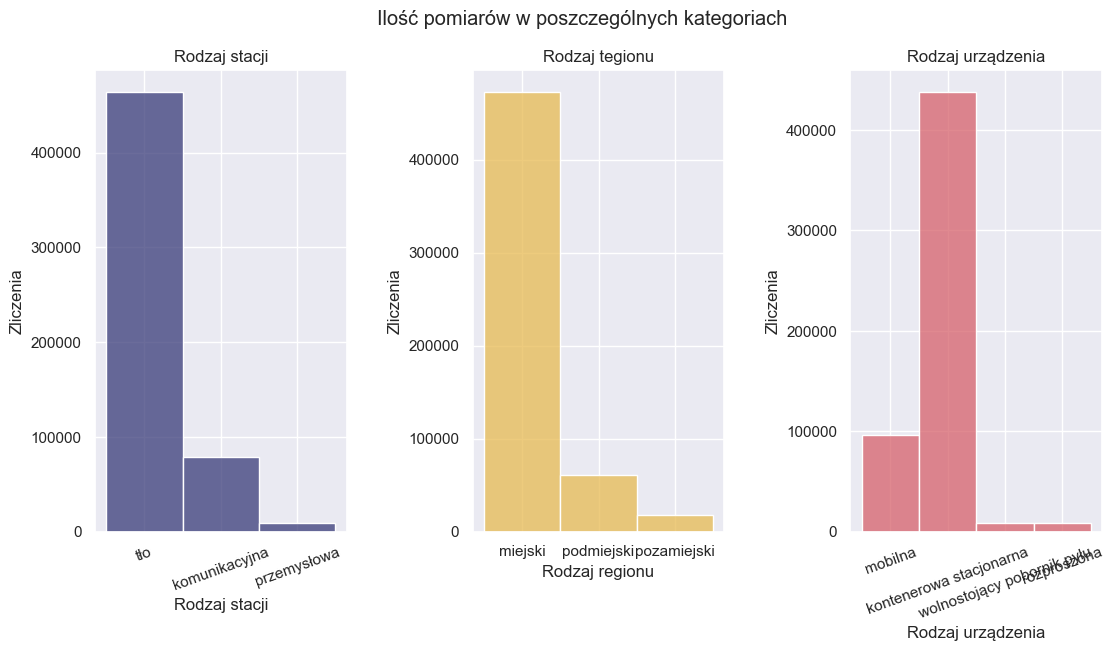

In [112]:
fig, axes = plt.subplots(1,3,figsize=(13,6))

sns.histplot(df.station_type, ax=axes[0], color=mpl.colormaps['tab20b'](0))
sns.histplot(df.region_type, ax=axes[1], color=mpl.colormaps['tab20b'](0.5))
sns.histplot(df.station_location_type, ax=axes[2], color=mpl.colormaps['tab20b'](0.7))

axes[0].tick_params(axis='x', labelrotation=20)
axes[2].tick_params(axis='x', labelrotation=20)

axes[0].set(xlabel='Rodzaj stacji', ylabel='Zliczenia', title='Rodzaj stacji')
axes[1].set(xlabel='Rodzaj regionu', ylabel='Zliczenia', title='Rodzaj tegionu')
axes[2].set(xlabel='Rodzaj urządzenia', ylabel='Zliczenia', title='Rodzaj urządzenia')

fig.suptitle('Ilość pomiarów w poszczególnych kategoriach')

plt.subplots_adjust(wspace=0.5)

plt.show()

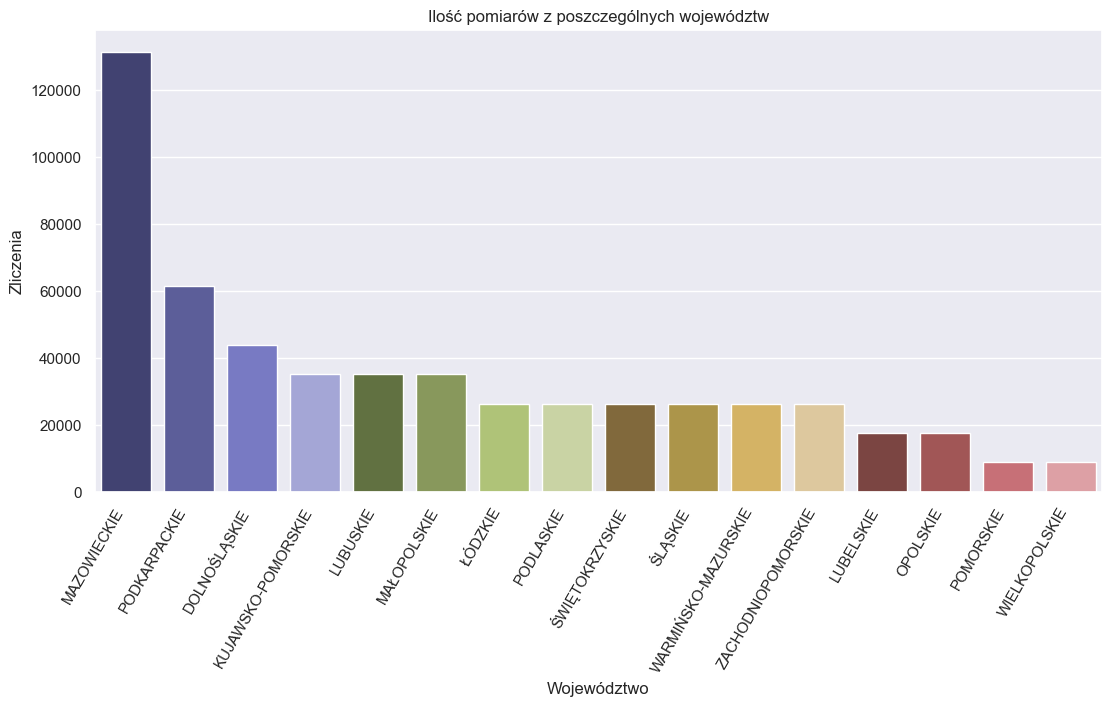

In [114]:
fig, ax = plt.subplots(1,1,figsize=(13,6))

v = df.voivodeship.value_counts()

sns.barplot(x=v.index, y=v.values, palette='tab20b', hue=v.index)
ax.set(title='Ilość pomiarów z poszczególnych województw', xlabel='Województwo', ylabel='Zliczenia')

plt.xticks(rotation=60, ha='right')
plt.show()

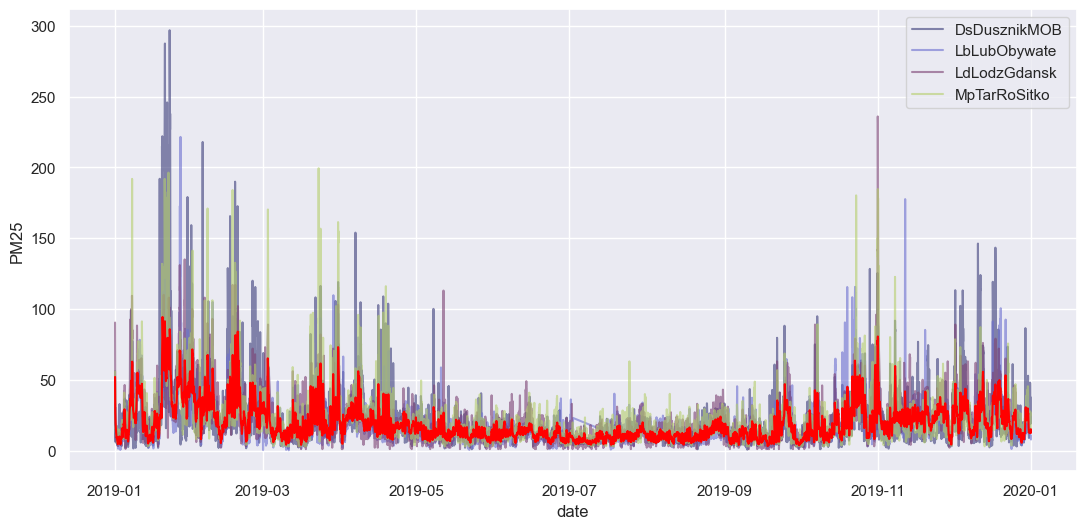

In [35]:
temp_stations_list = ['DsDusznikMOB', 'LbLubObywate', 'LdLodzGdansk', 'MpTarRoSitko']

tab20b = mpl.colormaps['tab20b']
palette_personalized =[tab20b(0/16), tab20b(2/16), tab20b(13/16), tab20b(5/16)]


temp = df[df.station_code.isin(temp_stations_list)]

means = df.groupby('date')['PM25'].mean()

fig, ax = plt.subplots(1,1,figsize=(13,6))

sns.lineplot(x=temp.date, y=temp.PM25, hue=temp.station_code, alpha=0.6, palette=palette_personalized, ax=ax)
sns.lineplot(x=means.index, y=means.values, ax=ax, color='red')

plt.show()

### Dodawanie cech (czas)

In [66]:
df.loc[:,'month'] = df.date.dt.month
df.loc[:,'day'] = df.date.dt.day
df.loc[:,'day_of_week'] = df.date.dt.day_of_week
df.loc[:,'day_of_year'] = df.date.dt.day_of_year
df.loc[:,'hour'] = df.date.dt.hour

df.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,day,day_of_week,day_of_year,hour
0,2019-01-01 01:00:00,DsDusznikMOB,33.40530,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,1
1,2019-01-01 02:00:00,DsDusznikMOB,13.80280,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,2
2,2019-01-01 03:00:00,DsDusznikMOB,9.94056,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,3
3,2019-01-01 04:00:00,DsDusznikMOB,6.75889,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,4
4,2019-01-01 05:00:00,DsDusznikMOB,7.88722,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,1,1,1,5


### Dane brakujące

In [184]:
# Sprawdzenie ilości brakujących danych

print(f'Procent brakujących danych w kolumnie PM25: {round(df["PM25"].isna().sum()/len(df)*100,2)}%')

Procent brakujących danych w kolumnie PM25: 4.43%


In [38]:
# Stworzenie ramki tylko z danymi brakującymi
only_missing = df[df.PM25.isna()]

only_missing.head()

,date,station_code,PM25,station_type,region_type,station_location_type,voivodeship,lat,lon,month,day,day_of_week,day_of_year,hour
492,2019-01-21 13:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,1,21,0,21,13
1379,2019-02-27 12:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,2,27,2,58,12
1504,2019-03-04 17:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,3,4,0,63,17
1505,2019-03-04 18:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,3,4,0,63,18
1655,2019-03-11 00:00:00,DsDusznikMOB,NaN,tło,miejski,mobilna,DOLNOŚLĄSKIE,50.402645,16.393319,3,11,0,70,0


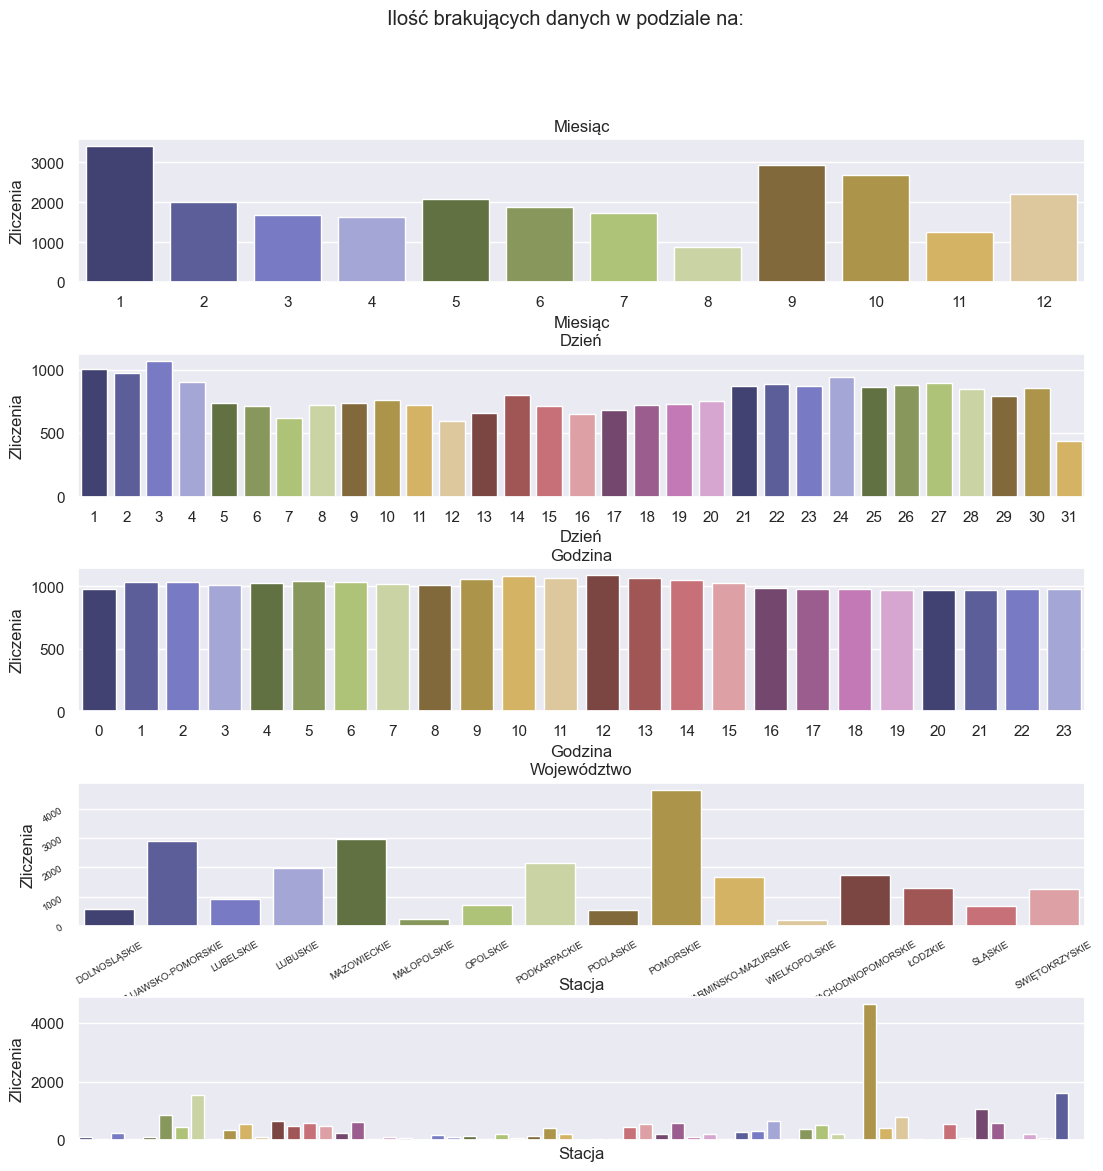

In [131]:
cols_to_check = ['month', 'day', 'hour', 'voivodeship', 'station_code']
plot_names = ['Miesiąc', 'Dzień', 'Godzina', 'Województwo', 'Stacja']

fig, axes = plt.subplots(len(cols_to_check), 1, figsize=(13,13))

for i, col in enumerate(cols_to_check):
    temp = only_missing.groupby(col)['station_code'].count()
    sns.barplot(x=temp.index, y=temp.values, ax=axes[i], palette='tab20b', hue=temp.index)
    axes[i].set(title=plot_names[i], xlabel=plot_names[i], ylabel='Zliczenia')

    if axes[i].get_legend() is not None:
        axes[i].get_legend().remove()
    

axes[3].tick_params(rotation=30, labelsize=7)

fig.suptitle('Ilość brakujących danych w podziale na:')
plt.subplots_adjust(hspace=0.5)
plt.xticks([])

plt.show()

In [44]:
# Sprawdzenie stacji z największą ilością brakujących danych
onms_counts = only_missing.station_code.value_counts()

onms_counts

station_code
PmGdaLeczkow        4648
ZpSzczBudzWosMOB    1620
KpToruDziewu        1547
WmElbBazynsk        1055
KpBydPlPozna         849
                    ... 
ZpSzczPilsud          25
SlBielPartyz          20
MpTarRoSitko          12
PkRzeszPilsu          11
WmOlsPuszkin           2
Name: count, Length: 63, dtype: int64

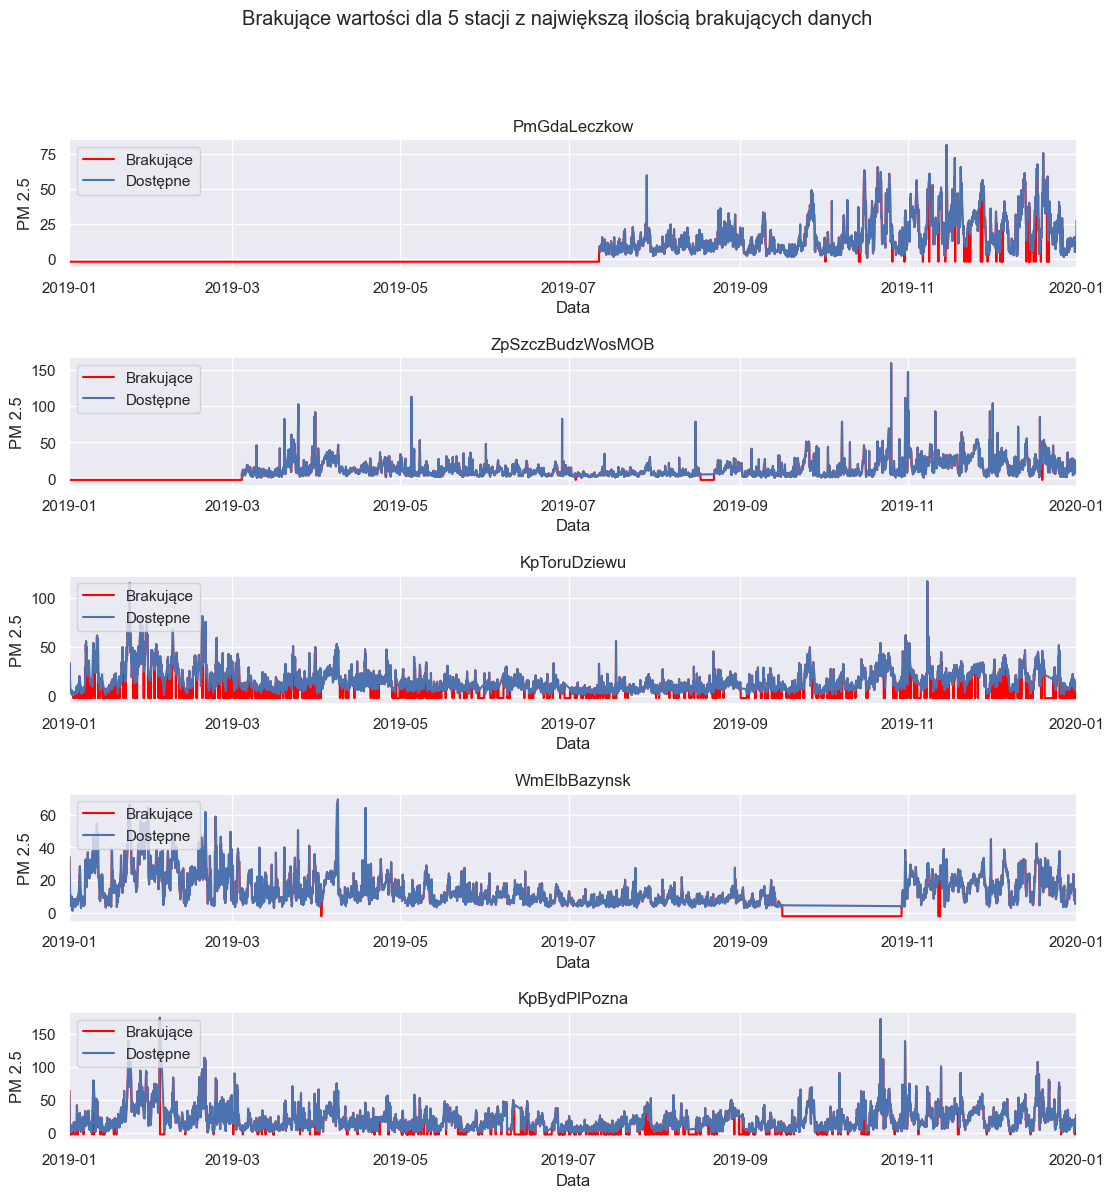

In [65]:
# Wykres pierwszych 5
onms_5 = onms_counts[:5]

fig, axes = plt.subplots(5,1,figsize=(13, 13))

for i, station in enumerate(onms_5.index):
    temp = df[df.station_code==station]
    na_s = temp['PM25'].fillna(-2)

    sns.lineplot(x=temp.date, y=na_s, color='red', ax=axes[i], label='Brakujące')
    sns.lineplot(x=temp.date, y=temp.PM25, ax=axes[i], label='Dostępne')
    axes[i].set(xlim=[pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01')], xlabel='Data', ylabel='PM 2.5', title=station)
    axes[i].legend(loc='upper left')

fig.suptitle('Brakujące wartości dla 5 stacji z największą ilością brakujących danych')
fig.subplots_adjust(hspace=0.7)

plt.show()

#To do opis

#### 1. Uzupełnianie przez interpolację (do 48 godzin) 

In [167]:
filled_df = df.copy()
filled_df['PM25'] = df.groupby('station_code')['PM25'].apply(lambda x: x.fillna(x.interpolate(limit=48))).reset_index(drop=True)
print(f'Procent brakujących danych w kolumnie PM25: {round(filled_df["PM25"].isna().sum()/len(filled_df)*100,2)}%')

#### 2. Uzupełnianie przez średnią wojewódzką

In [152]:
filled_df.groupby('voivodeship')['station_code'].nunique()

voivodeship
DOLNOŚLĄSKIE            5
KUJAWSKO-POMORSKIE      4
LUBELSKIE               2
LUBUSKIE                4
MAZOWIECKIE            15
MAŁOPOLSKIE             4
OPOLSKIE                2
PODKARPACKIE            7
PODLASKIE               3
POMORSKIE               1
WARMIŃSKO-MAZURSKIE     3
WIELKOPOLSKIE           1
ZACHODNIOPOMORSKIE      3
ŁÓDZKIE                 3
ŚLĄSKIE                 3
ŚWIĘTOKRZYSKIE          3
Name: station_code, dtype: int64

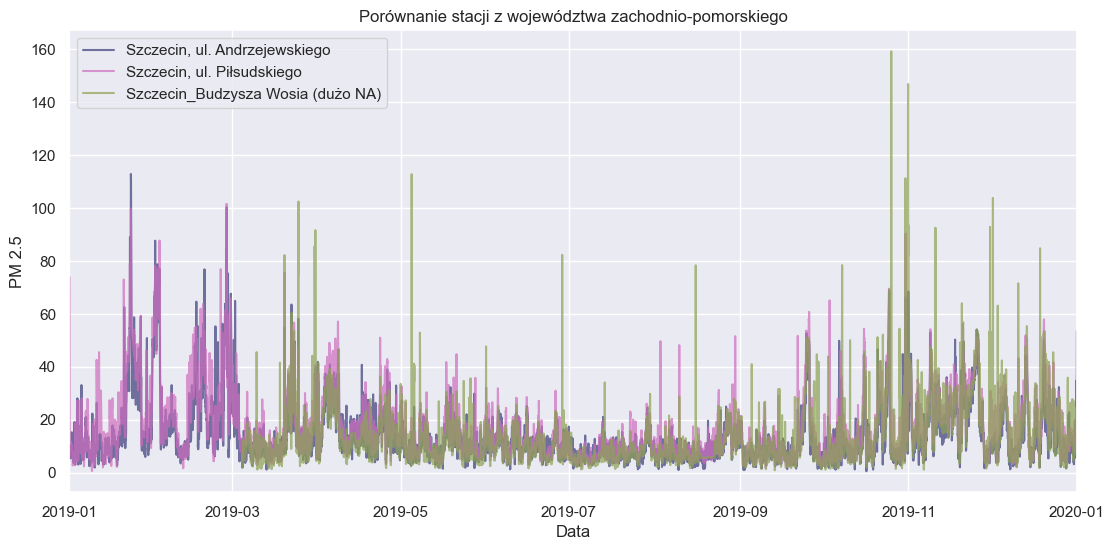

In [166]:
temp = filled_df[filled_df.station_code=='ZpSzczAndrze']
temp2 = filled_df[filled_df.station_code=='ZpSzczBudzWosMOB']
temp3 = filled_df[filled_df.station_code=='ZpSzczPilsud']

fig, ax = plt.subplots(1,1,figsize=(13,6))
sns.lineplot(x=temp.date, y=temp.PM25, ax=ax, label='Szczecin, ul. Andrzejewskiego', color=tab20b(0/16), alpha=0.7)
sns.lineplot(x=temp3.date, y=temp3.PM25, ax=ax, label='Szczecin, ul. Piłsudskiego', color=tab20b(15/16), alpha=0.7)
sns.lineplot(x=temp2.date, y=temp2.PM25, ax=ax, label='Szczecin_Budzysza Wosia (dużo NA)', color=tab20b(4/16), alpha=0.7)

ax.set(xlim=[pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01')], xlabel='Data', ylabel='PM 2.5',
        title='Porównanie stacji z województwa zachodnio-pomorskiego')

plt.show()

In [ ]:
# dokonczyc to

#### 3. Uzupełnianie reszty brakujących danych

In [ ]:
# sprawdzic dla jakich stacji brakuje

Ostateczne wyniki uzupełniania danych przedstawiają się następująco. Na wykresie przedstawiono te same stacje, które były pokazane wcześniej.

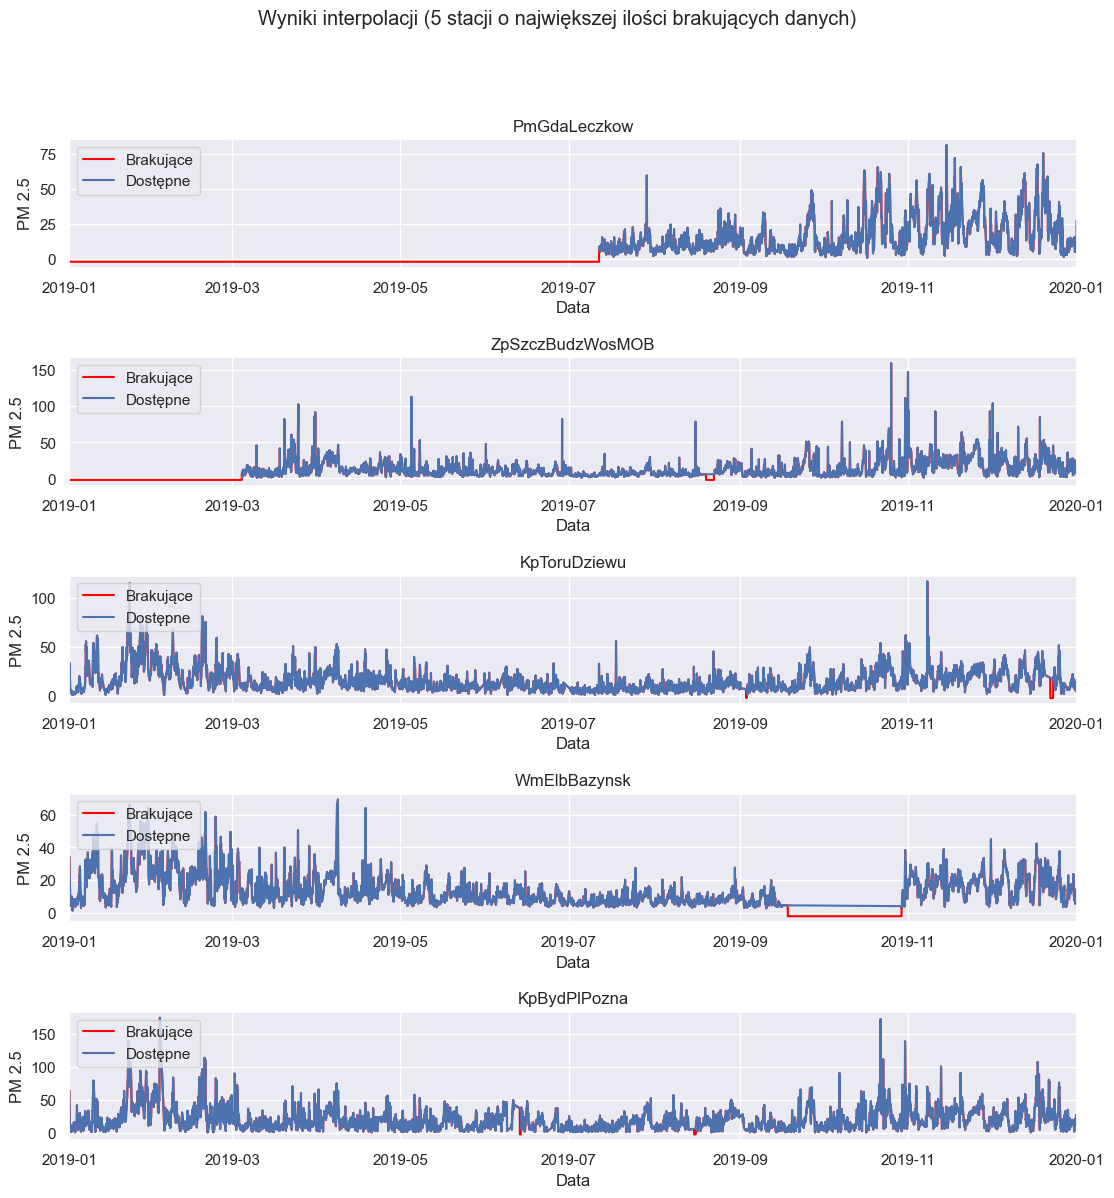

In [168]:
fig, axes = plt.subplots(5,1,figsize=(13, 13))

for i, station in enumerate(onms_5.index):
    temp = filled_df[filled_df.station_code==station]
    na_s = temp['PM25'].fillna(-2)

    sns.lineplot(x=temp.date, y=na_s, color='red', ax=axes[i], label='Brakujące')
    sns.lineplot(x=temp.date, y=temp.PM25, ax=axes[i], label='Dostępne')
    axes[i].set(xlim=[pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01')], xlabel='Data', ylabel='PM 2.5', title=station)
    axes[i].legend(loc='upper left')

fig.suptitle('Wyniki interpolacji (5 stacji o największej ilości brakujących danych)')
fig.subplots_adjust(hspace=0.7)

plt.show()